In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(1)

# Workshop Functions\n",
import sys
sys.path.append('..')
from WKDSS420_functions import * 

In [2]:
from surprise import Dataset
from surprise import Reader

Scikit-surprise information can be found here: https://pypi.org/project/scikit-surprise/

In [3]:
df = pd.read_csv('MovieLensCombined.csv')
df.head()
# item_id corresponds to a unique movie title

,Unnamed: 0,user_id,item_id,rating,timestamp,title
0,4650,1,1,5,874965758,Toy Story (1995)
1,30297,1,10,3,875693118,Richard III (1995)
2,8426,1,100,5,878543541,Fargo (1996)
3,84479,1,101,2,878542845,Heavy Metal (1981)
4,81145,1,102,2,889751736,"Aristocats, The (1970)"


### Data Exploration

In [4]:
df.info()
# we see that there are 100K observations, mean rating is high at 3.5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  100000 non-null  int64 
 1   user_id     100000 non-null  int64 
 2   item_id     100000 non-null  int64 
 3   rating      100000 non-null  int64 
 4   timestamp   100000 non-null  int64 
 5   title       100000 non-null  object
dtypes: int64(5), object(1)
memory usage: 4.6+ MB


In [5]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

# Need to convert user_id, item_id, timestamp to string
df['user_id'] = df['user_id'].astype(str)
df['item_id'] = df['item_id'].astype(str)
df['timestamp'] = df['timestamp'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    100000 non-null  object
 1   item_id    100000 non-null  object
 2   rating     100000 non-null  int64 
 3   timestamp  100000 non-null  object
 4   title      100000 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [6]:
df.loc[:,'user_id'].nunique() # number of unique users

943

In [7]:
df.loc[:,'item_id'].nunique() # number of unique movies (items)

1682

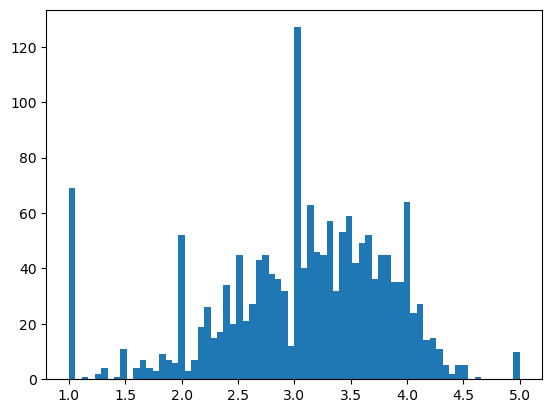

In [8]:
mean_ratings = df.groupby('title')['rating'].mean()
plt.hist(mean_ratings, bins=70)
plt.show()
# we see some spikes around the whole numbers, which are the rating options given to the users.  
# We're also seeing a large spike at 3.0.  This is because if a movies was not particularly good or bad in my opinion, 
# ...I split the difference and give it a 3.  And it seems many users do the same.
# Also there is a large spike of 1.0 or bad movies.  

In [9]:
# let's sort so the highest rated movies are on the top
mean_ratings.sort_values(ascending=False)

title
They Made Me a Criminal (1939)                  5.0
Marlene Dietrich: Shadow and Light (1996)       5.0
Saint of Fort Washington, The (1993)            5.0
Someone Else's America (1995)                   5.0
Star Kid (1997)                                 5.0
                                               ... 
Eye of Vichy, The (Oeil de Vichy, L') (1993)    1.0
King of New York (1990)                         1.0
Touki Bouki (Journey of the Hyena) (1973)       1.0
Bloody Child, The (1996)                        1.0
Crude Oasis, The (1995)                         1.0
Name: rating, Length: 1664, dtype: float64

You'll notice that the highest rated movies are relatively unknown or limited release.  That's because these were probably rated by just one or a handful of viewers who all loved the movie.  But such a small number of raters for a movie is not representative of the general public.  

To see a better effect, try grouping by the count instead of the mean

In [10]:
num_of_ratings = df.groupby('title')['rating'].count().sort_values(ascending=False)
# these movies are much more what we would think of when we think of generally popular movies.
num_of_ratings.head()

title
Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [11]:
# More advanced method that shows the mean and the count, sorted by count.
df.groupby('title')['rating'].agg(['count', 'mean']).sort_values(by='count', ascending=False)
# these movies are much more what we would think of when we think of generally popular movies.

,count,mean
title,,
Star Wars (1977),583,4.358491
Contact (1997),509,3.803536
Fargo (1996),508,4.155512
Return of the Jedi (1983),507,4.007890
Liar Liar (1997),485,3.156701
...,...,...
"Great Day in Harlem, A (1994)",1,5.000000
"Other Voices, Other Rooms (1997)",1,3.000000
Good Morning (1971),1,1.000000


<AxesSubplot:>

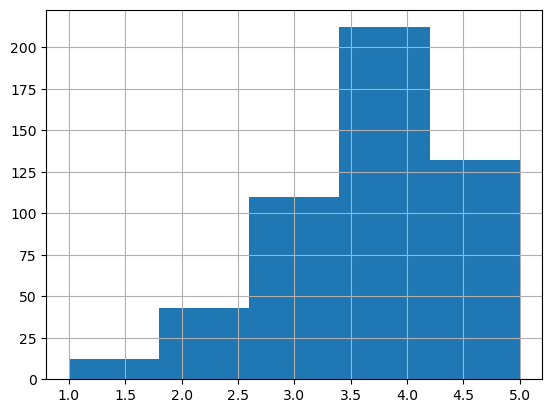

In [12]:
# OPTIONAL: when you get more people rating a movie, you start getting a normal distribution of ratings.  
df.loc[df.loc[:,'title']=='Contact (1997)','rating'].hist(bins=5)

In [13]:
# Let's store this in a dataframe to use later
df2 = df.groupby('title')['rating'].agg(['count', 'mean']).sort_values(by='count', ascending=False)
df2.columns = ['num_of_ratings', 'mean_rating']
df2.head()

,num_of_ratings,mean_rating
title,,
Star Wars (1977),583,4.358491
Contact (1997),509,3.803536
Fargo (1996),508,4.155512
Return of the Jedi (1983),507,4.007890
Liar Liar (1997),485,3.156701


In [14]:
df2.loc['They Made Me a Criminal (1939)','num_of_ratings']
# the more unknown movies have one 1 rating

1

In [15]:
# what are these movies with just one rating?
df2.loc[df2.loc[:,'num_of_ratings']<2,:]

,num_of_ratings,mean_rating
title,,
"Silence of the Palace, The (Saimt el Qusur) (1994)",1,3.0
Someone Else's America (1995),1,5.0
Shopping (1994),1,2.0
"Bloody Child, The (1996)",1,1.0
"Vie est belle, La (Life is Rosey) (1987)",1,1.0
...,...,...
"Great Day in Harlem, A (1994)",1,5.0
"Other Voices, Other Rooms (1997)",1,3.0
Good Morning (1971),1,1.0


In [16]:
df2.loc[df2.loc[:,'num_of_ratings']<2,'num_of_ratings'].count()
# 134 movies with just one rating.  This will affect our predictions later on.

134

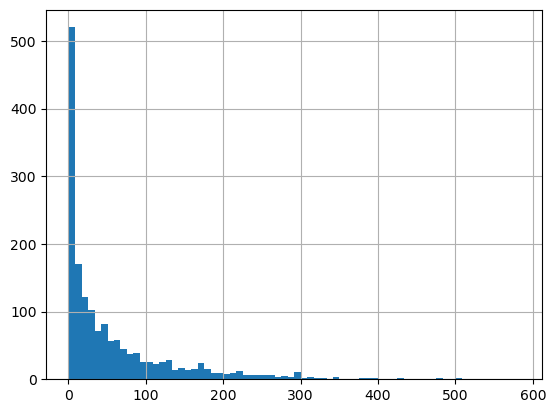

In [17]:
df2.loc[:,'num_of_ratings'].hist(bins=70)
plt.show()

This plot shows the number of ratings that each movie got.  Most movies have just a few ratings.  There are a lot of movies that got only a handful of reviewers.  Most movies are not blockbusters, and so there are only a few that are in the large count range on the right hand side of the histogram.  

Finally, let's check the relationship between average rating and the number of ratings

Text(5, 5, 'Less popular movie, \nRated by few similar viewers ')

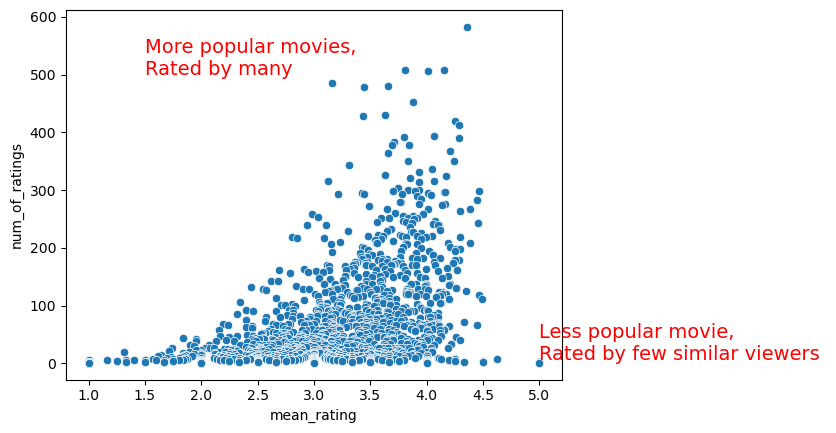

In [18]:
ax = sns.scatterplot(x=df2.loc[:,'mean_rating'], y=df2.loc[:,'num_of_ratings'])
ax.text(1.5,500,'More popular movies,\nRated by many',color='red',fontsize=14)
ax.text(5,5,'Less popular movie, \nRated by few similar viewers ',color='red',fontsize=14)

We see that there is some relationship betwen the 2 variables, generally showing that as the number of ratings goes up, the overall value of the ratings goes up too (positive trend).  

Most of the populat movies with >500 reviews are popular and above the 3.5 mean.  And movies with very few reviwers span the gamut from 1-5 stars.  

### Convert data to scikit-surprise format

In [19]:
df.head()

,user_id,item_id,rating,timestamp,title
0,1,1,5,874965758,Toy Story (1995)
1,1,10,3,875693118,Richard III (1995)
2,1,100,5,878543541,Fargo (1996)
3,1,101,2,878542845,Heavy Metal (1981)
4,1,102,2,889751736,"Aristocats, The (1970)"


In [20]:
from surprise import Dataset, Reader
reader = Reader(rating_scale=(1, 5))
# From the library author: "The columns must correspond to user id, item id and ratings (in that order)."
data = Dataset.load_from_df(df[["user_id", "item_id", "rating"]], reader)

### Cosine Similarity
Let's do the cosine similarity to find recommendations from users that are similar to a target user. This is a **memory-based** collaborative filter which we discussed in the lecture.  

We will user K-Near Neighbors to find the *K* users that are closest to the target user as determined through the cosine similarity between them, where similar users will have a smaller angle between the vectors representing the users.

In [21]:
from surprise import KNNWithMeans
# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": True  # Compute  similarities between users (False = between items, which is Content Based Filtering)
}
algo = KNNWithMeans(sim_options=sim_options)

In [22]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.25)

algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [23]:
prediction = algo.predict(2, 19) #(user, item_id)
prediction.est

3.52916

In [24]:
#movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles = pd.read_csv("Movie_Id_Titles",index_col='item_id')
movie_titles.head()

,title
item_id,
1,Toy Story (1995)
2,GoldenEye (1995)
3,Four Rooms (1995)
4,Get Shorty (1995)
5,Copycat (1995)


In [25]:
predictions = algo.test(testset)

from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 0.9580


0.9580361272648452

In [26]:
top_n = get_top_n(predictions, movie_titles, n=3)

In [27]:
predictions[0]

Prediction(uid='533', iid='708', r_ui=2.0, est=3.231142678363929, details={'actual_k': 40, 'was_impossible': False})

In [28]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

533 [title    Close Shave, A (1995)
Name: 408, dtype: object, title    Usual Suspects, The (1995)
Name: 12, dtype: object, title    Wizard of Oz, The (1939)
Name: 132, dtype: object]
747 [title    Close Shave, A (1995)
Name: 408, dtype: object, title    Casablanca (1942)
Name: 483, dtype: object, title    Dr. Strangelove or: How I Learned to Stop Worr...
Name: 474, dtype: object]
664 [title    Close Shave, A (1995)
Name: 408, dtype: object, title    Wrong Trousers, The (1993)
Name: 169, dtype: object, title    Shawshank Redemption, The (1994)
Name: 64, dtype: object]
835 [title    Titanic (1997)
Name: 313, dtype: object, title    Good Will Hunting (1997)
Name: 272, dtype: object, title    One Flew Over the Cuckoo's Nest (1975)
Name: 357, dtype: object]
345 [title    Graduate, The (1967)
Name: 197, dtype: object, title    Star Wars (1977)
Name: 50, dtype: object, title    Waiting for Guffman (1996)
Name: 1007, dtype: object]
450 [title    Schindler's List (1993)
Name: 318, dtype: object

286 [title    Shall We Dance? (1996)
Name: 251, dtype: object, title    Good Will Hunting (1997)
Name: 272, dtype: object, title    Secrets & Lies (1996)
Name: 285, dtype: object]
868 [title    Godfather: Part II, The (1974)
Name: 187, dtype: object, title    Wrong Trousers, The (1993)
Name: 169, dtype: object, title    Star Wars (1977)
Name: 50, dtype: object]
579 [title    Rear Window (1954)
Name: 603, dtype: object, title    Alien (1979)
Name: 183, dtype: object, title    Strictly Ballroom (1992)
Name: 709, dtype: object]
339 [title    Vertigo (1958)
Name: 479, dtype: object, title    Godfather, The (1972)
Name: 127, dtype: object, title    Stripes (1981)
Name: 1301, dtype: object]
807 [title    Empire Strikes Back, The (1980)
Name: 172, dtype: object, title    Fugitive, The (1993)
Name: 79, dtype: object, title    Killing Fields, The (1984)
Name: 528, dtype: object]
599 [title    My Best Friend's Wedding (1997)
Name: 255, dtype: object, title    Truth About Cats & Dogs, The (1996)


465 [title    Wallace & Gromit: The Best of Aardman Animatio...
Name: 114, dtype: object, title    Close Shave, A (1995)
Name: 408, dtype: object, title    Usual Suspects, The (1995)
Name: 12, dtype: object]
395 [title    Schindler's List (1993)
Name: 318, dtype: object, title    Boot, Das (1981)
Name: 515, dtype: object, title    Empire Strikes Back, The (1980)
Name: 172, dtype: object]
443 [title    Usual Suspects, The (1995)
Name: 12, dtype: object, title    Titanic (1997)
Name: 313, dtype: object, title    Thin Blue Line, The (1988)
Name: 644, dtype: object]
367 [title    Chasing Amy (1997)
Name: 246, dtype: object, title    City of Lost Children, The (1995)
Name: 919, dtype: object, title    Aliens (1986)
Name: 176, dtype: object]
254 [title    One Flew Over the Cuckoo's Nest (1975)
Name: 357, dtype: object, title    Alien (1979)
Name: 183, dtype: object, title    Forrest Gump (1994)
Name: 69, dtype: object]
871 [title    Lawrence of Arabia (1962)
Name: 511, dtype: object, title  

700 [title    Wrong Trousers, The (1993)
Name: 169, dtype: object, title    Star Wars (1977)
Name: 50, dtype: object, title    Glory (1989)
Name: 651, dtype: object]
113 [title    Kolya (1996)
Name: 242, dtype: object, title    A Chef in Love (1996)
Name: 1251, dtype: object, title    English Patient, The (1996)
Name: 286, dtype: object]
547 [title    Wag the Dog (1997)
Name: 347, dtype: object, title    Deconstructing Harry (1997)
Name: 345, dtype: object, title    Kiss the Girls (1997)
Name: 332, dtype: object]
604 [title    Fargo (1996)
Name: 100, dtype: object, title    Twelve Monkeys (1995)
Name: 7, dtype: object, title    Jaws (1975)
Name: 234, dtype: object]
736 [title    Star Wars (1977)
Name: 50, dtype: object, title    Grosse Pointe Blank (1997)
Name: 248, dtype: object, title    Return of the Jedi (1983)
Name: 181, dtype: object]
364 [title    Chasing Amy (1997)
Name: 268, dtype: object, title    Full Monty, The (1997)
Name: 269, dtype: object, title    Anna Karenina (1997)


In [29]:
# Get the top 3 movie recommendations for user 1
top_n['1']

[(title    12 Angry Men (1957)
  Name: 178, dtype: object,
  4.3197601180826855),
 (title    Godfather: Part II, The (1974)
  Name: 187, dtype: object,
  4.285693128177548),
 (title    Bridge on the River Kwai, The (1957)
  Name: 199, dtype: object,
  4.190897569401593)]

In [30]:
# What are the top movies the person has rated:
df.loc[df.loc[:,'user_id']=='1',['title','rating']].sort_values(by='rating',ascending=False).head(20)

,title,rating
0,Toy Story (1995),5
143,Star Trek: The Wrath of Khan (1982),5
138,Sling Blade (1996),5
130,When Harry Met Sally... (1989),5
121,Young Frankenstein (1974),5
120,Cyrano de Bergerac (1990),5
117,Back to the Future (1985),5
115,Groundhog Day (1993),5
109,Nikita (La Femme Nikita) (1990),5
108,"Graduate, The (1967)",5


#### What Happened???
User 1 has rated many popular movies very high.  So why is the recommender suggesting movies that very few people have watched? 

Remember that there were a lot of movies that were mostly unknown, had just 1 or 2 reviewers that rated them 5 stars?  These are affecting the recommendations of movies.  

***Curiosity Points (15 points)*** In the original dataframe **df** filter out the movies that have just a few reviews.  Play around with the threshold until you start getting good recommendations.  

#### Plotting cosine similarities

In [31]:
# First create a blank matrix to hold a 0 if a movie was not rated, and the user rating otherwise
recArr = np.zeros((3,1682))

In [32]:
u1 = np.array(df.loc[ df.loc[:,'user_id']=='1', ['item_id','rating' ]])
u2 = np.array(df.loc[ df.loc[:,'user_id']=='2', ['item_id','rating' ]])
u3 = np.array(df.loc[ df.loc[:,'user_id']=='3', ['item_id','rating' ]])

In [33]:
np.array(u1).shape

(272, 2)

In [34]:
counter=0
for x in [u1,u2,u3]:    
    r,c = x.shape
    for y in range(r):
        recArr[counter,int(x[y,0])] = x[y,1]
    counter = counter+1
    
recArr[:,0:10] 

array([[0., 5., 3., 4., 3., 3., 5., 4., 1., 5.],
       [0., 4., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [35]:
mags = np.linalg.norm(recArr, axis=1)
dots01 = np.dot(recArr[0,:],recArr[1,:])
dots02 = np.dot(recArr[0,:],recArr[2,:])

Angle01 = dots01/(mags[0]*mags[1]) 
Angle02 = dots01/(mags[0]*mags[2]) 
print(mags)
print(Angle01, Angle02)

Angle01Rad = Angle01/np.pi
Angle02Rad = Angle02/np.pi

u01Coord = mags[1]*np.array([np.cos(Angle01Rad),np.sin(Angle01Rad)])
print(u01Coord)

u02Coord = mags[2]*np.array([np.cos(Angle02Rad),np.sin(Angle02Rad)])
print(u02Coord)

[63.07138812 30.29851482 22.38302929]
0.16693098386870195 0.22596409196036782
[30.25575229  1.60917781]
[22.32515565  1.6085475 ]


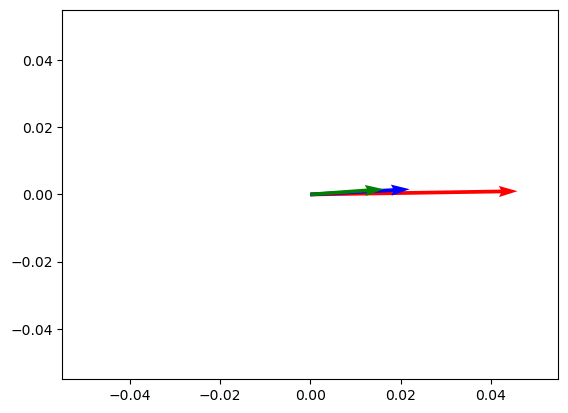

In [36]:
# We have the vector magnitudes and angles - let's plot
V = np.array([[mags[0],1],u01Coord, u02Coord])
origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=151)

#### Running a Grid Search 
A grid search allows you to specify various options for your hyper-parameters of your recommender algorithm.  The **gridsearch** will then go through each option and you can retrieve the best option.  

In [37]:
from surprise import KNNWithMeans

help(KNNWithMeans)

Help on class KNNWithMeans in module surprise.prediction_algorithms.knns:

class KNNWithMeans(SymmetricAlgo)
 |  KNNWithMeans(k=40, min_k=1, sim_options={}, verbose=True, **kwargs)
 |  
 |  A basic collaborative filtering algorithm, taking into account the mean
 |  ratings of each user.
 |  
 |  The prediction :math:`\hat{r}_{ui}` is set as:
 |  
 |  .. math::
 |      \hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)}
 |      \text{sim}(u, v) \cdot (r_{vi} - \mu_v)} {\sum\limits_{v \in
 |      N^k_i(u)} \text{sim}(u, v)}
 |  
 |  or
 |  
 |  .. math::
 |      \hat{r}_{ui} = \mu_i + \frac{ \sum\limits_{j \in N^k_u(i)}
 |      \text{sim}(i, j) \cdot (r_{uj} - \mu_j)} {\sum\limits_{j \in
 |      N^k_u(i)} \text{sim}(i, j)}
 |  
 |  depending on the ``user_based`` field of the ``sim_options`` parameter.
 |  
 |  
 |  Args:
 |      k(int): The (max) number of neighbors to take into account for
 |          aggregation (see :ref:`this note <actual_k_note>`). Default is
 |          ``4

In [38]:
param_grid = {
    'k' : [3,5,10,20,40],
    'sim_options': {
        'name' : ['msd','cosine'], 
        'user_based': [True, False],
    },
}
# "msd" = MSE (Mean Square Error)

In [39]:
from surprise.model_selection import GridSearchCV

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse","mae"],cv=None)
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


In [40]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.loc[:,'params']

0     {'k': 3, 'sim_options': {'name': 'msd', 'user_...
1     {'k': 3, 'sim_options': {'name': 'msd', 'user_...
2     {'k': 3, 'sim_options': {'name': 'cosine', 'us...
3     {'k': 3, 'sim_options': {'name': 'cosine', 'us...
4     {'k': 5, 'sim_options': {'name': 'msd', 'user_...
5     {'k': 5, 'sim_options': {'name': 'msd', 'user_...
6     {'k': 5, 'sim_options': {'name': 'cosine', 'us...
7     {'k': 5, 'sim_options': {'name': 'cosine', 'us...
8     {'k': 10, 'sim_options': {'name': 'msd', 'user...
9     {'k': 10, 'sim_options': {'name': 'msd', 'user...
10    {'k': 10, 'sim_options': {'name': 'cosine', 'u...
11    {'k': 10, 'sim_options': {'name': 'cosine', 'u...
12    {'k': 20, 'sim_options': {'name': 'msd', 'user...
13    {'k': 20, 'sim_options': {'name': 'msd', 'user...
14    {'k': 20, 'sim_options': {'name': 'cosine', 'u...
15    {'k': 20, 'sim_options': {'name': 'cosine', 'u...
16    {'k': 40, 'sim_options': {'name': 'msd', 'user...
17    {'k': 40, 'sim_options': {'name': 'msd', '

In [41]:
print(gs.best_score)

print(gs.best_params)

{'rmse': 0.9343347267627697, 'mae': 0.7333597329308995}
{'rmse': {'k': 40, 'sim_options': {'name': 'msd', 'user_based': False}}, 'mae': {'k': 40, 'sim_options': {'name': 'msd', 'user_based': False}}}


### Recommender System with Matrix Factorization
Here we will practice how to use Matrix Factorization with Singular Vector Decomposition (SVD).  

An excellent description of SVD can be found here if you wish to explore: https://towardsdatascience.com/understanding-singular-value-decomposition-and-its-application-in-data-science-388a54be95d

In [42]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.25)

In [43]:
from surprise import SVD, accuracy
algo = SVD(n_factors=2) # default is 100
algo.fit(trainset)

In [44]:
user_factors = algo.pu
item_factors = algo.qi

In [45]:
predictions = algo.test(testset)

In [46]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 0.9397


0.939711039640099

**Online User Results** For reference, this website (https://surpriselib.com/) shows the results for different combinations of parameters for this dataset ("Movielens 100k")

In [47]:
top_n = get_top_n(predictions, movie_titles, n=3)

In [48]:
top_n['1']

[(title    Star Wars (1977)
  Name: 50, dtype: object,
  4.3587473650816895),
 (title    Wallace & Gromit: The Best of Aardman Animatio...
  Name: 114, dtype: object,
  4.324322966459863),
 (title    Blade Runner (1982)
  Name: 89, dtype: object,
  4.2379589227569125)]

####  Grid search
Let's do a grid search with various parameters to see which are best for this dataset.  You can set any of the parameters for the SVD function described here (https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) in the **param_grid** dict

In [49]:
from surprise.model_selection import GridSearchCV

param_grid = {"n_epochs": [5, 10,15,20], "lr_all": [0.001, 0.002, 0.005,0.010],"n_factors" : [2,10,100]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=None)

gs.fit(data)

# best RMSE score
print(gs.best_score)

# combination of parameters that gave the best RMSE score
print(gs.best_params)

{'rmse': 0.9327141570995291, 'mae': 0.7338237115576696}
{'rmse': {'n_epochs': 20, 'lr_all': 0.01, 'n_factors': 2}, 'mae': {'n_epochs': 15, 'lr_all': 0.01, 'n_factors': 10}}
